In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
import skimage as skimage

Clear the Keras session

In [2]:
K.clear_session()

# Load data

All the data we used is from https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/. we only used WIKI face only dataset with about 22000+ face images. Before we started, we get rid off some invalid images such as images without face and images of people whose ages are over 100 or below 0. In addition we split data into training and test with rate 2 to 1 and read them with ImageDataGenerator. More detail is on another notebook.

In [3]:
#Load train data
train_data_dir = './train'
batch_size = 256
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224,224),
    batch_size=batch_size)

#Load test data
test_data_dir = './test'
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224,224),
    batch_size=batch_size)


Found 16606 images belonging to 101 classes.
Found 5534 images belonging to 101 classes.


# Construct model

The model we used is VGG-Face which created by Omkar M. Parkhi, Andrea Vedaldi and Andrew Zisserman in *Deep Face Recognition*. The structure of the model is as following:

<img src="https://i0.wp.com/sefiks.com/wp-content/uploads/2019/04/vgg-face-architecture.jpg?w=1805&ssl=1">

To use the model, first we should construct the model manually.

In [4]:
#print(Xts.shape, yts.shape, Xtr.shape, ytr.shape)

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Then we load the pretrained weights (also offered by those reseachers). We locked the model's layer weights except last 7 layers because early layers could detect some patterns. Then we cut the last convolution layer to replace it with 101 units (ages from 0 to 100) but not 2622 units. 

In [5]:
#Load weights for VGG-model
model.load_weights('vgg_face_weights.h5')
#Make the VGG-model layers untrainable except last 7 layers
for layer in model.layers[:-7]:
    layer.trainable = False
#Change the last Convolution layer into 101 output(from age 0 to 100)

model_output = Sequential()
model_output = Convolution2D(101, (1, 1), name='predictions')(model.layers[-4].output)
model_output = Flatten()(model_output)
model_output = Activation('softmax')(model_output)

age_model = Model(inputs=model.input, outputs=model_output)
age_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_input (InputL (None, 224, 224, 3)       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
__________

# Fit model

Because the data is little, so we only need 3 epochs to train the model (more epochs will cause overfit), and each epoch we go through all the data we have.

In [6]:
#Using Loss funtion 'categorial crossentropy' and Optimization algorithm 'Adam'
age_model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(), metrics=['accuracy'])
#Make a checkpoint in case it goes wrong
checkpointer = ModelCheckpoint(
    filepath='age_model.hdf5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    mode='auto')
#Training the model
epochs = 3
steps_per_epoch = train_generator.n//batch_size
validation_steps = test_generator.n//batch_size
#Call the fit_generator function
hist = age_model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=validation_steps,
    callbacks=[checkpointer])

'''
scores = []
for i in range(epochs):
    print("epoch", i)
    
    iXtr = np.random.choice(Xtr.shape[0], size=batch_size)
    
    score = age_model.fit(Xtr[iXtr], ytr[iXtr], epochs=1, validation_data=(Xts, yts))
    
    scores.append(score)
'''

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
22/22 [==============================] - 27s 1s/step - loss: 3.4742 - acc: 0.0589

Epoch 00001: val_loss improved from inf to 3.47419, saving model to age_model.hdf5
65/65 [==============================] - 97s 1s/step - loss: 3.7652 - acc: 0.0479 - val_loss: 3.4742 - val_acc: 0.0589
Epoch 2/3
22/22 [==============================] - 24s 1s/step - loss: 3.4063 - acc: 0.0631

Epoch 00002: val_loss improved from 3.47419 to 3.40632, saving model to age_model.hdf5
65/65 [==============================] - 94s 1s/step - loss: 3.4271 - acc: 0.0702 - val_loss: 3.4063 - val_acc: 0.0631
Epoch 3/3
22/22 [==============================] - 24s 1s/step - loss: 3.4028 - acc: 0.0605

Epoch 00003: val_loss improved from 3.40632 to 3.40284, saving model to age_model.hdf5
65/65 [==============================] - 93s 1s/step - loss: 3.2730 - acc: 0.0927 - val_loss: 3.4028 - val_acc: 0.0605


'\nscores = []\nfor i in range(epochs):\n    print("epoch", i)\n    \n    iXtr = np.random.choice(Xtr.shape[0], size=batch_size)\n    \n    score = age_model.fit(Xtr[iXtr], ytr[iXtr], epochs=1, validation_data=(Xts, yts))\n    \n    scores.append(score)\n'

# Result

We can find out the accuracy is 6% which seems very low. However, it is actually not. We all know that guess the exact right age is very hard and all we need is a range of possible ages, so we need some processes to get the right prediction. But first, we should plot the training loss and validation loss vs. epoch.

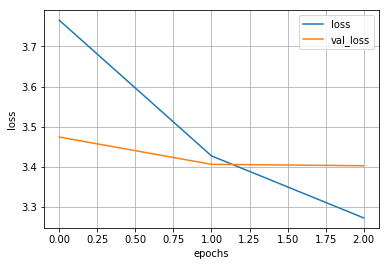

In [7]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.plot(loss)
plt.plot(val_loss)
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss','val_loss'])
plt.show()

Reseachers developed a way to convert classifcation into regression. They proposed that we should multiply each softmax out with its corresponded label. Summing this multiplications, which we knew is the math expectation, will be the apparent age prediction.

In [8]:
#Predict ages on a batch of test data
Xts, yts = test_generator.next()
#Multiply each softmax out with its label. 
#Summing this multiplications will get a apparent age prediction
predictions = age_model.predict(Xts)
output_indexes = np.array([i for i in range(0, 101)])
apparent_predictions = np.around(np.sum(predictions*output_indexes, axis=1))

yts_actual = np.empty(yts.shape[0], dtype=int)
for i in range(0, yts.shape[0]):
    yts_actual[i] = np.argmax(yts[i])

#Compute the mean absolute error
error = np.mean(np.abs(apparent_predictions - yts_actual))
print("The mean absolute error is: {0:0.1f}".format(error))

The mean absolute error is: 5.7


The mean absolute error of a batch of test data is 6, which is somehow acceptable. To get a more accurate result, you simple need more data.

We plot some test images below, so you can see the result visually.

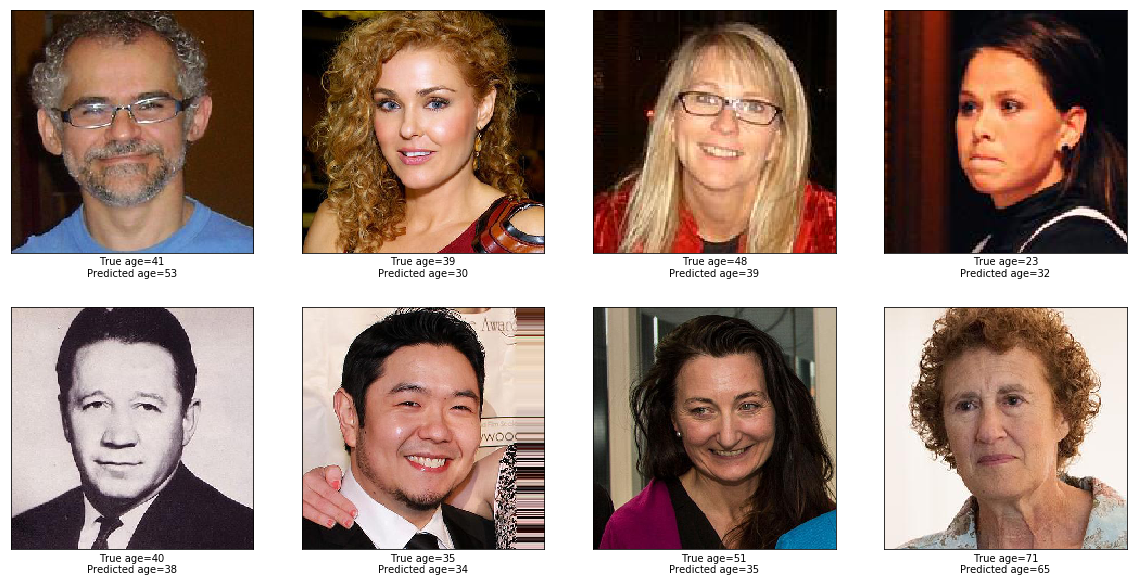

In [9]:
# Display the image
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im)
    else:
        # Color image.
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)

    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

plt.figure(figsize=(20,10))
nplot = 8
for i in range(nplot):
    plt.subplot(2, 4, i+1)
    disp_image(Xts[i])
    plt.xlabel('True age={0:d}\nPredicted age={1:.0f}'.format(yts_actual[i], apparent_predictions[i]))
plt.show()

Then we use the picture of Kit Harington, the actor of Jon Snow in the *Game of Thrones*, to make a prediction. The picture is taken in 2019 when he is 32 years old. 

Text(0.5, 0, 'True age=32\nPredicted age=31')

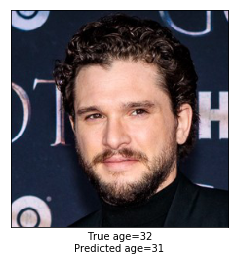

In [10]:
myImage = skimage.io.imread('jon_snow.jpg')
myImage_r = skimage.transform.resize(myImage, (224,224), anti_aliasing=True)
y = age_model.predict(myImage_r[None,:,:,:])
apparent_y = np.around(np.sum(y*output_indexes, axis=1))
disp_image(myImage_r)
plt.xlabel('True age={0:d}\nPredicted age={1:.0f}'.format(32, apparent_y[0]))

The result is pretty good.